In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location
from setup import add_project_root
add_project_root()

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from models.inverse.CNO_inverse_models import CNOInverseClassifier
from models.inverse.FNO_inverse_models import FNOInverseClassifier

from evaluate_inverse_functions import *

import time
import japanize_matplotlib

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
test_data = torch.load('../data/datasets/data/darcy_test_16.pt')
test_data_32 = torch.load("../data/datasets/data/darcy_test_32.pt")
x_test = test_data["y"].unsqueeze(1).float()
y_test = test_data["x"].unsqueeze(1).float()
x_test_32 = test_data_32["y"].unsqueeze(1).float()
y_test_32 = test_data_32["x"].unsqueeze(1).float()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cno = CNOInverseClassifier().to(device)
cno.load_state_dict(torch.load("../results/inverse/checkpoints/best_CNO_inverse_model.pth", map_location=device))
cno.eval()

fno = FNOInverseClassifier(modes1=8, modes2=8, width=32).to(device)
fno.load_state_dict(torch.load("../results/inverse/checkpoints/best_FNO_inverse_model.pth", map_location=device))
fno.eval()

x_test = x_test.to(device)
y_test = y_test.to(device)

x_test_32 = x_test_32.to(device)
y_test_32 = y_test_32.to(device)

threshold = 0.5 



In [5]:
# --- 実行フェーズ ---
inference_times = {}
metrics = {}
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
with torch.no_grad():

    # CNO
    t_cno, m_cno, pred_cno = measure_inference_and_eval(cno, x_test, y_test, binarize=True, warmup=10, repeat=100)
    inference_times["CNO"] = t_cno
    metrics["CNO"] = m_cno
    print(count_params(cno))


    # FNO
    x_test_fno = x_test.permute(0, 2, 3, 1)  # (B, H, W, 1)
    t_fno, m_fno,pred_fno = measure_inference_and_eval(fno, x_test_fno, y_test,binarize=True,warmup=10,repeat=100)
    inference_times["FNO"] = t_fno
    metrics["FNO"] = m_fno
    print(count_params(fno))

    y_true = y_test.cpu()  

# --- 結果表示 ---
summary_metrics_table_binary(inference_times,metrics,)


torch.float32 torch.float32
416481
torch.float32 torch.float32
204257
【評価結果：2値分類】

【推論時間（ms）】
CNO            : 0.77 ms
FNO            : 0.95 ms

【評価指標（2値分類）】
Model             Accuracy        IoU       Dice
--------------------------------------------------
CNO                 0.9417     0.8718     0.9191
FNO                 0.9378     0.8604     0.9087


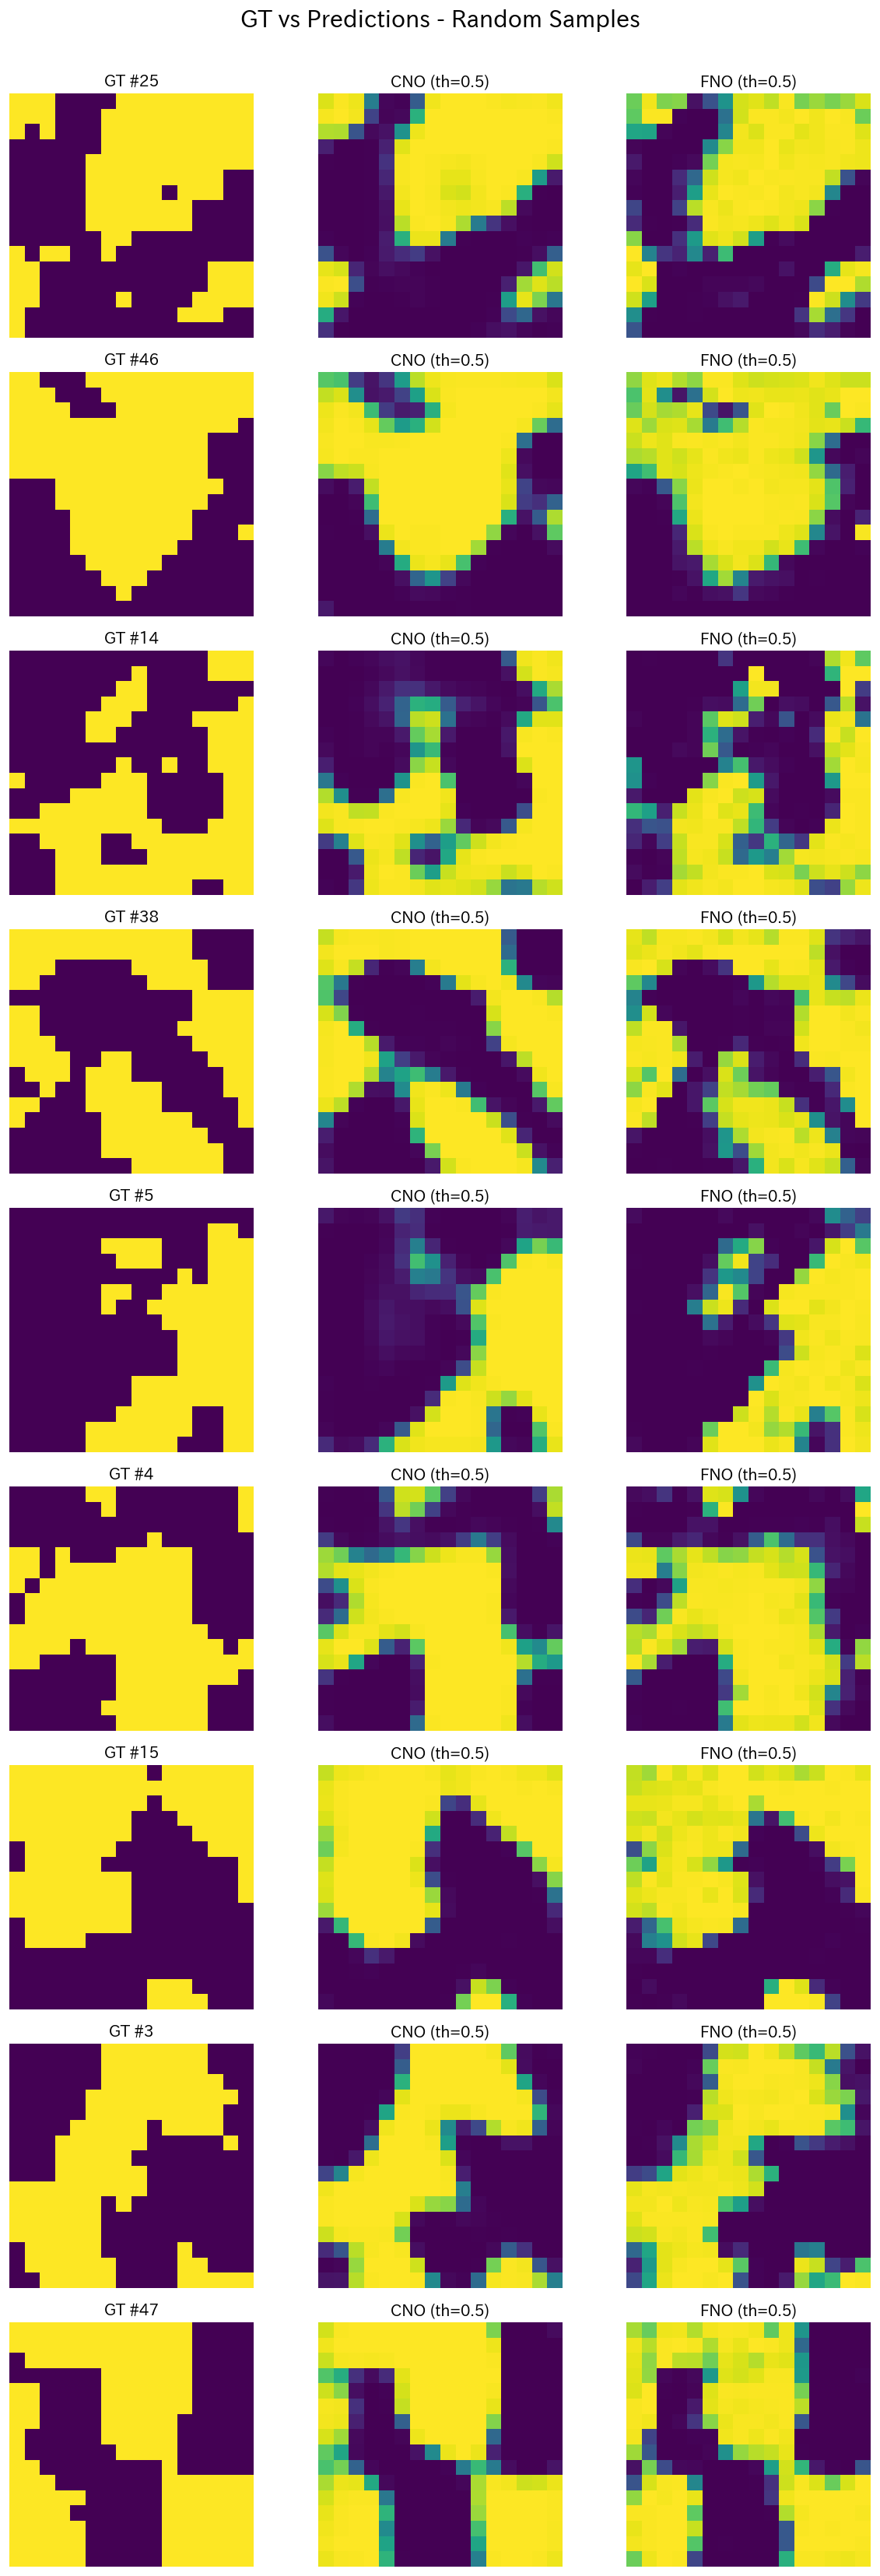

In [6]:
gt_images = y_true.squeeze(1)                    # [B, 1, H, W] → [B, H, W]

cno_images = pred_cno.squeeze(1)               # [B, 1, H, W] → [B, H, W]
fno_images = pred_fno.squeeze(-1)  # [B, 1, H, W] → [B, H, W]             

preds = [cno_images, fno_images]
labels = ["CNO", "FNO"]
plot_random_binary_predictions(gt_images,preds,labels,threshold=threshold)

c:\Users\natsu\OneDrive - 国立大学法人東北大学\研究室\python\FNOorCNN\root\notebooks\evaluate_inverse_functions.py:191: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.96])


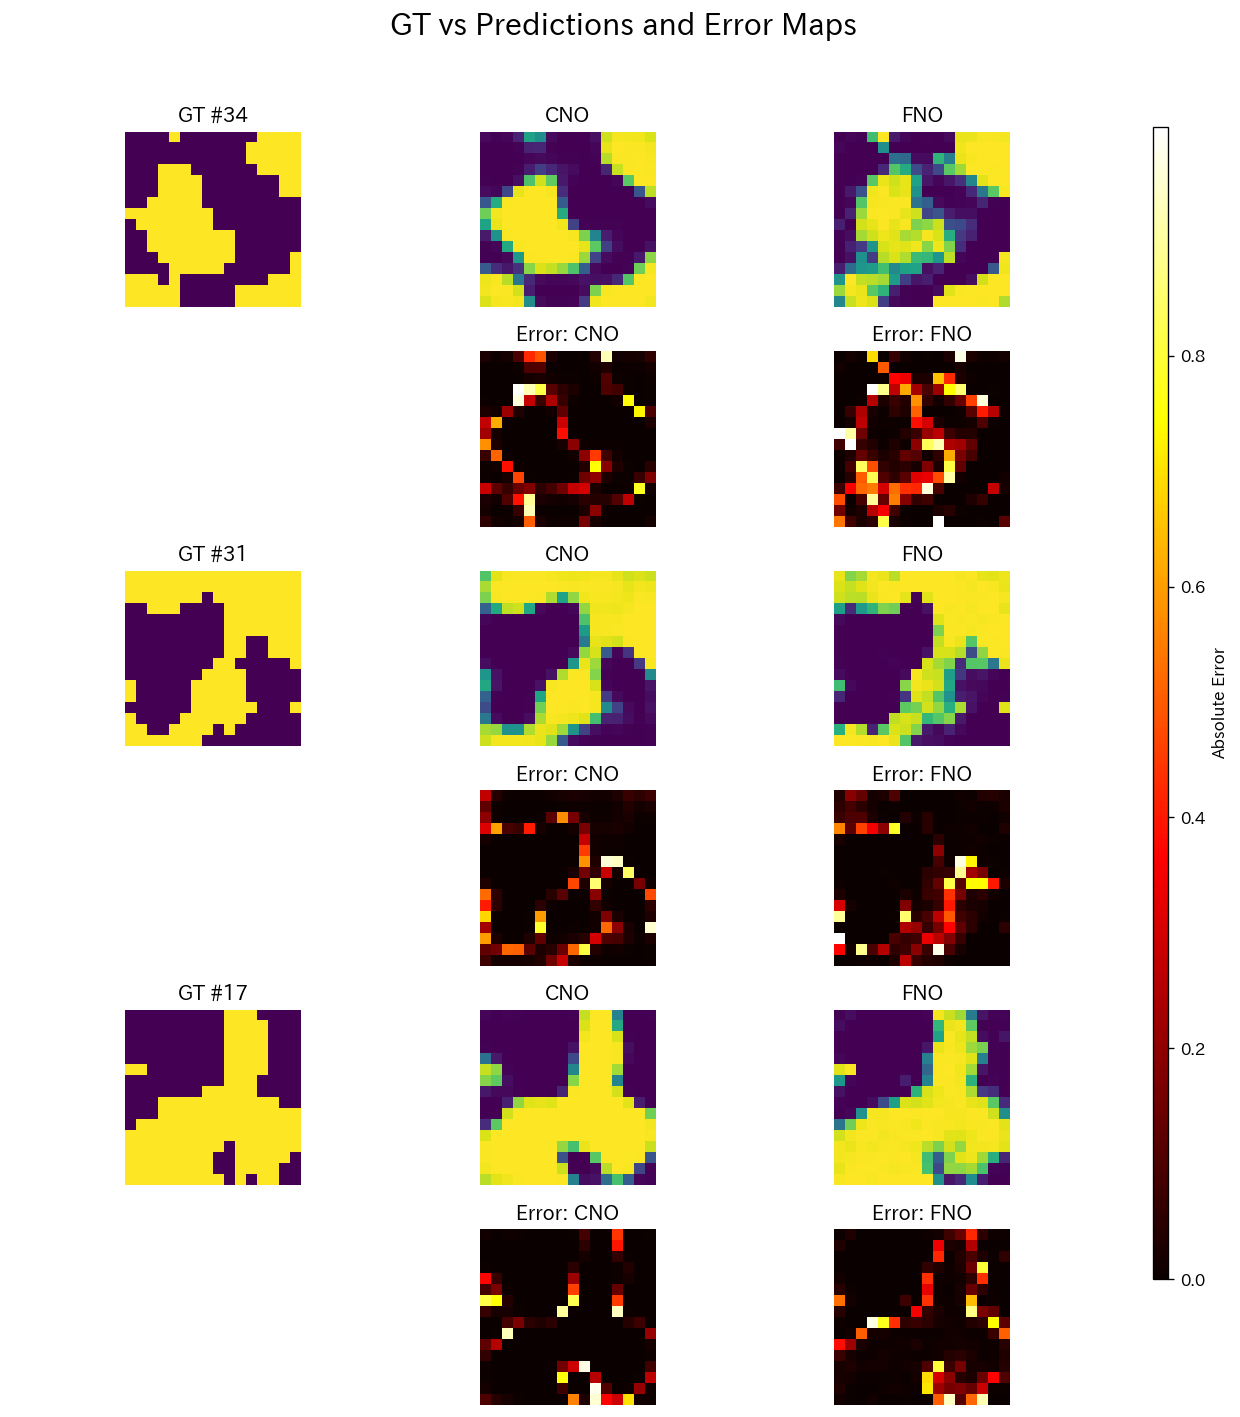

In [7]:
plot_prediction_and_error_maps(gt_images,preds,labels,num_samples=3)

FP: 357, FN: 389


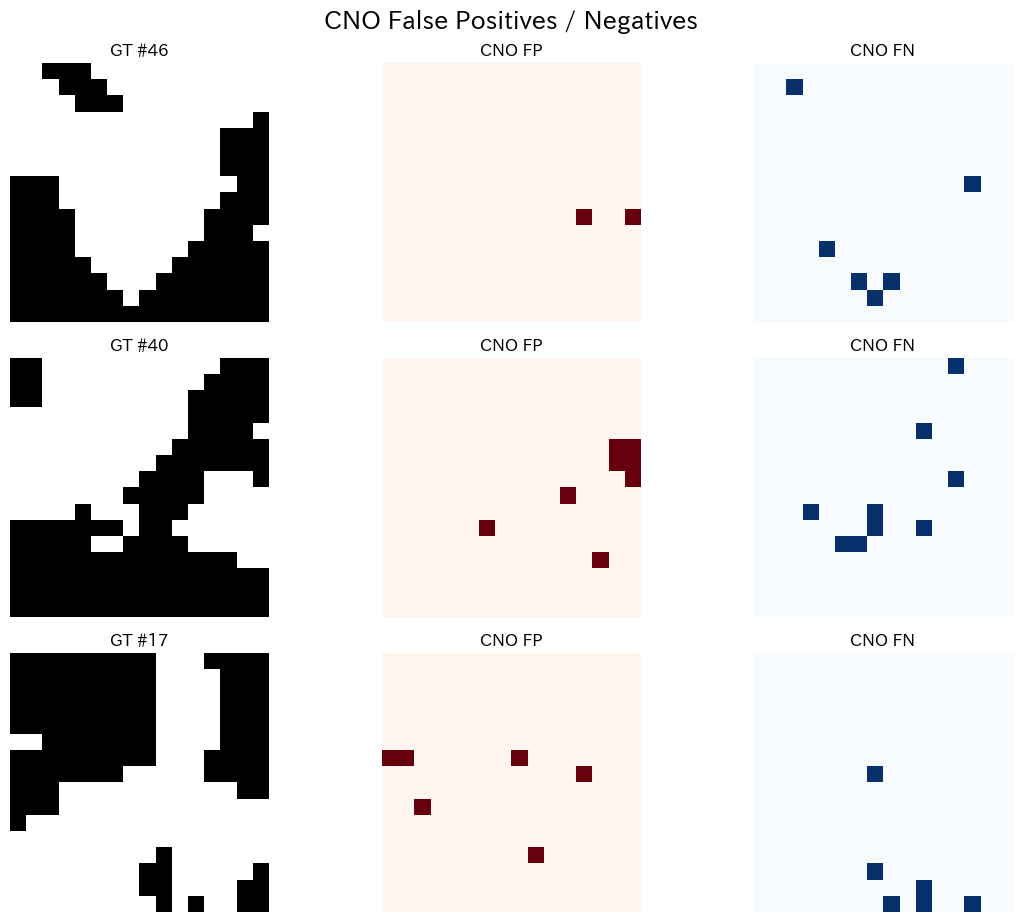

FP: 472, FN: 324


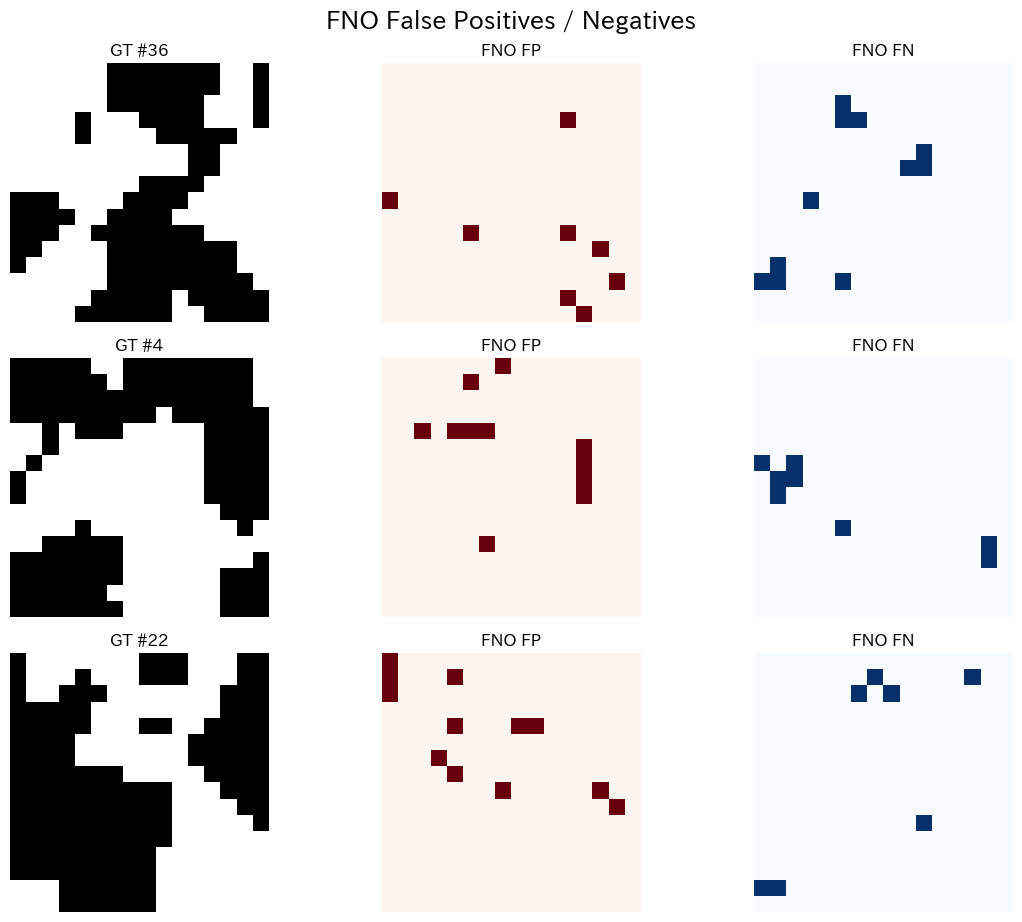

In [8]:

plot_fp_fn_examples(pred_cno, y_true, model_name="CNO",num_samples=3)
plot_fp_fn_examples(pred_fno, y_true, model_name="FNO",num_samples=3)

In [9]:
inference_times_32 = {}
metrics_32 = {}


with torch.no_grad():

    
    # CNO
    t_cno_32, m_cno_32, pred_cno_32 = measure_inference_and_eval(cno, x_test_32, y_test_32, warmup=10, repeat=100)
    inference_times_32["CNO"] = t_cno_32
    metrics_32["CNO"] = m_cno_32


    # FNO
    x_test_fno_32 = x_test_32.permute(0, 2, 3, 1)
    t_fno_32, m_fno_32, pred_fno_32 = measure_inference_and_eval(fno, x_test_fno_32, y_test_32,  warmup=10, repeat=100)
    inference_times_32["FNO"] = t_fno_32
    metrics_32["FNO"] = m_fno_32

    # 可視化用GT保存
    y_true_32 = y_test_32.cpu()

summary_metrics_table_binary(inference_times_32, metrics_32)

torch.float32 torch.float32
torch.float32 torch.float32
【評価結果：2値分類】

【推論時間（ms）】
CNO            : 1.79 ms
FNO            : 2.10 ms

【評価指標（2値分類）】
Model             Accuracy        IoU       Dice
--------------------------------------------------
CNO                 0.7514     0.6463     0.7541
FNO                 0.9234     0.8332     0.8940


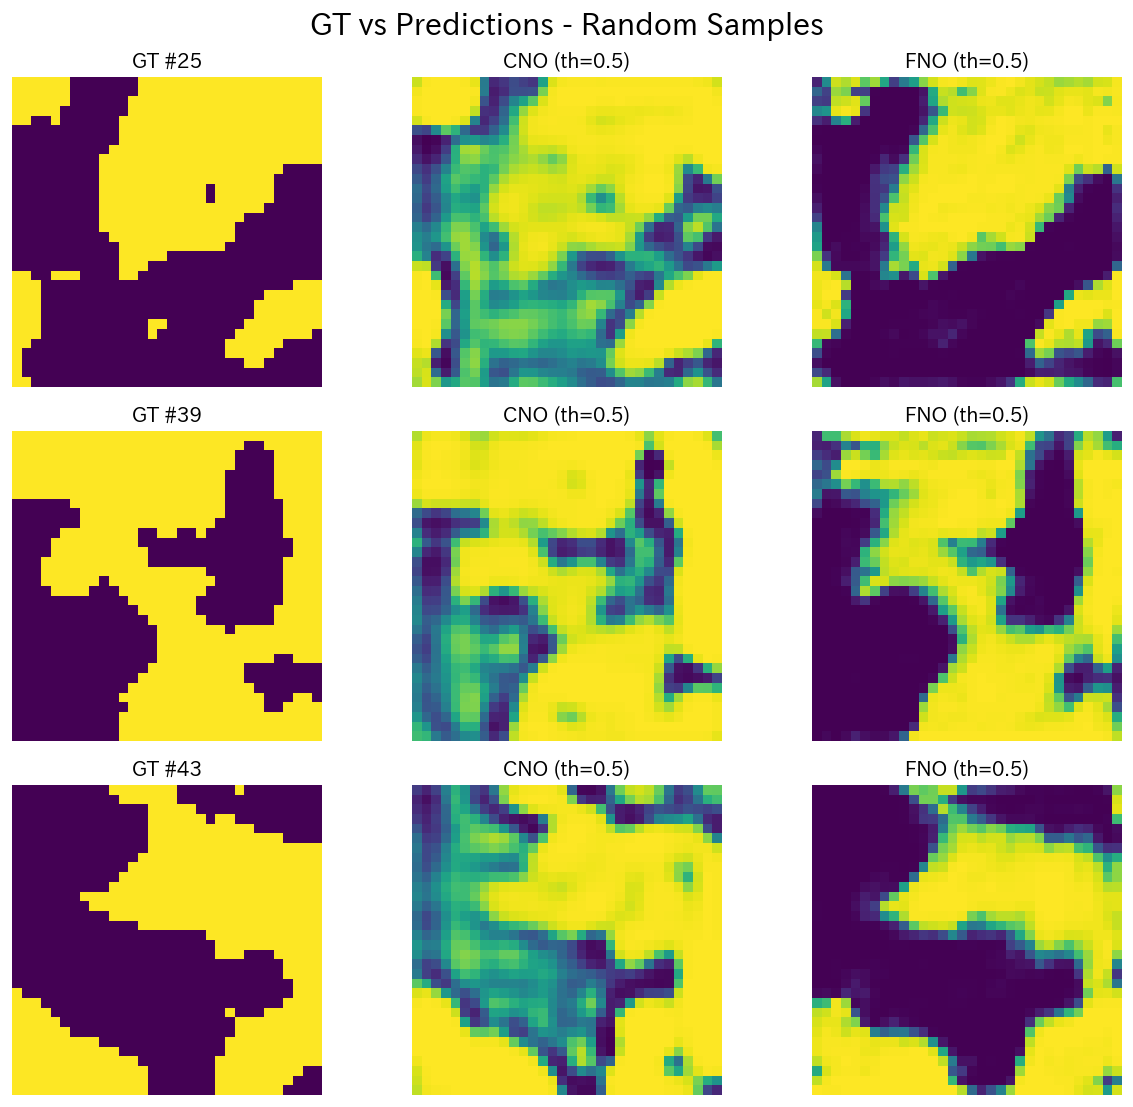

In [11]:
gt_images_32 = y_true_32.squeeze(1)                    # [B, 1, H, W] → [B, H, W]
cno_images_32 = pred_cno_32.squeeze(1)               # [B, 1, H, W] → [B, H, W]
fno_images_32 = pred_fno_32.squeeze(-1)                # [B, H, W, 1]

preds_32 = [cno_images_32, fno_images_32]
labels_32 = ["CNO", "FNO"]

plot_random_binary_predictions(gt_images_32, preds_32,labels_32, threshold=threshold,num_samples=3)


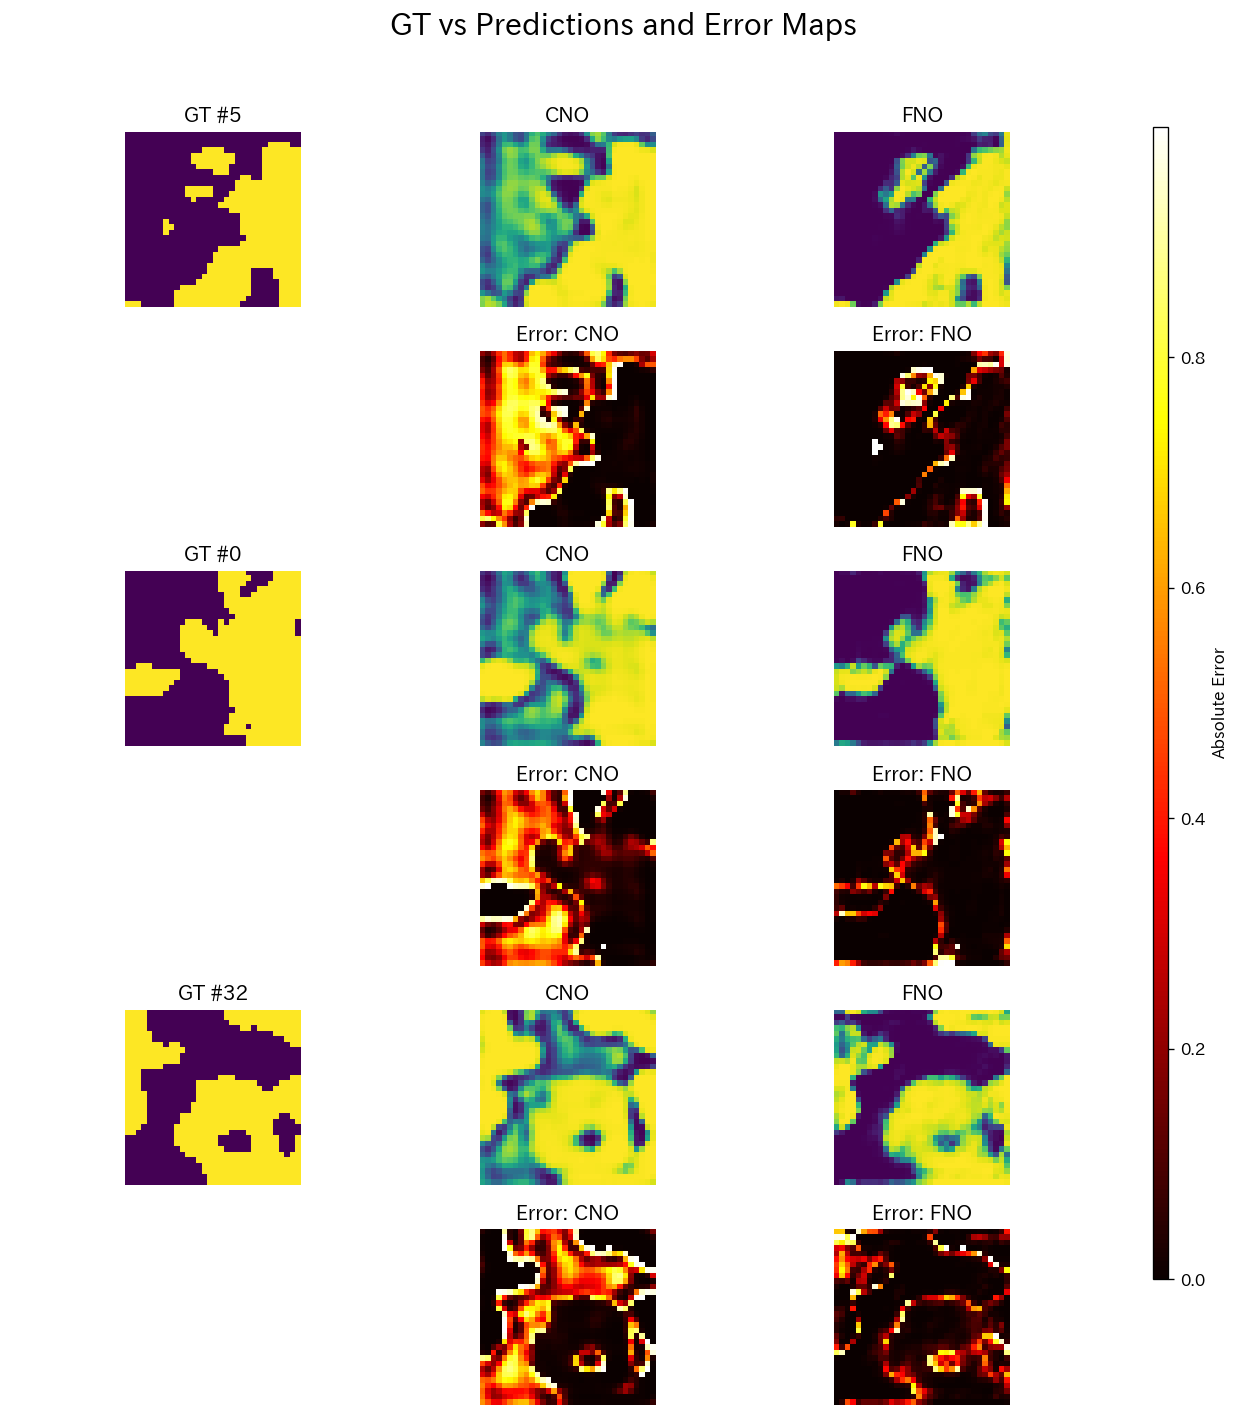

FP: 12541, FN: 189


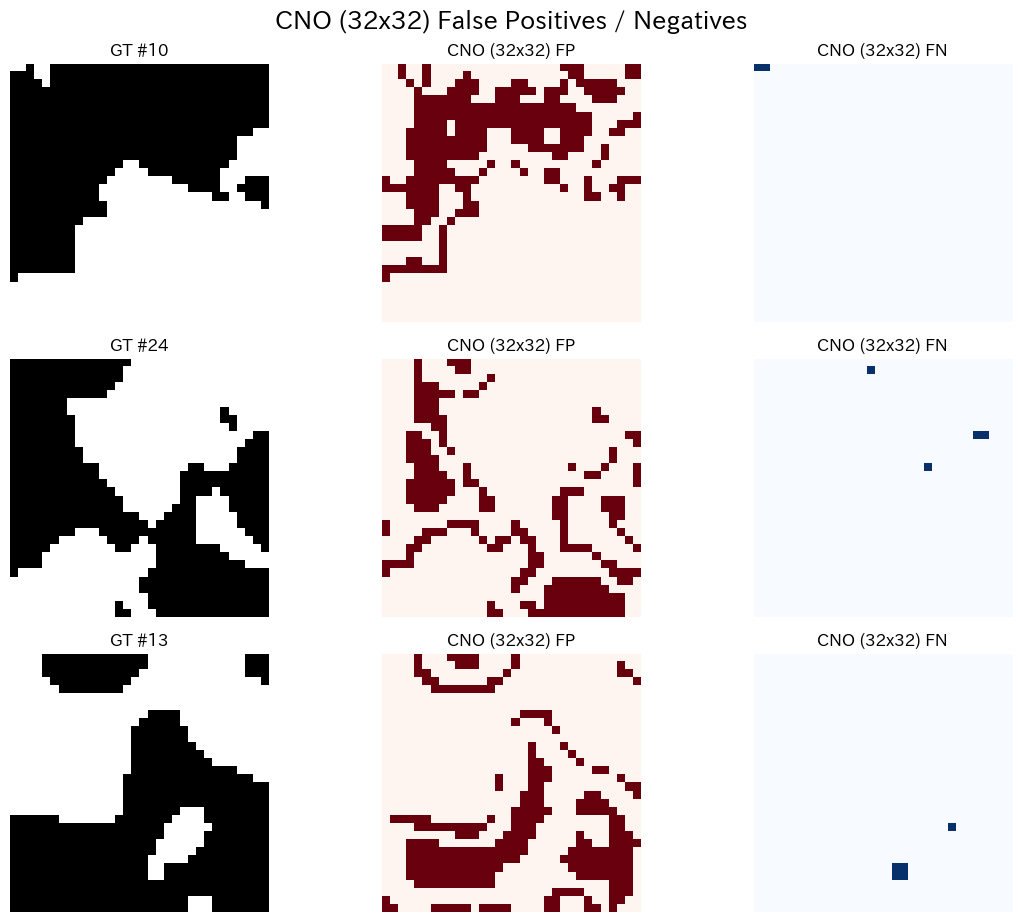

FP: 2280, FN: 1642


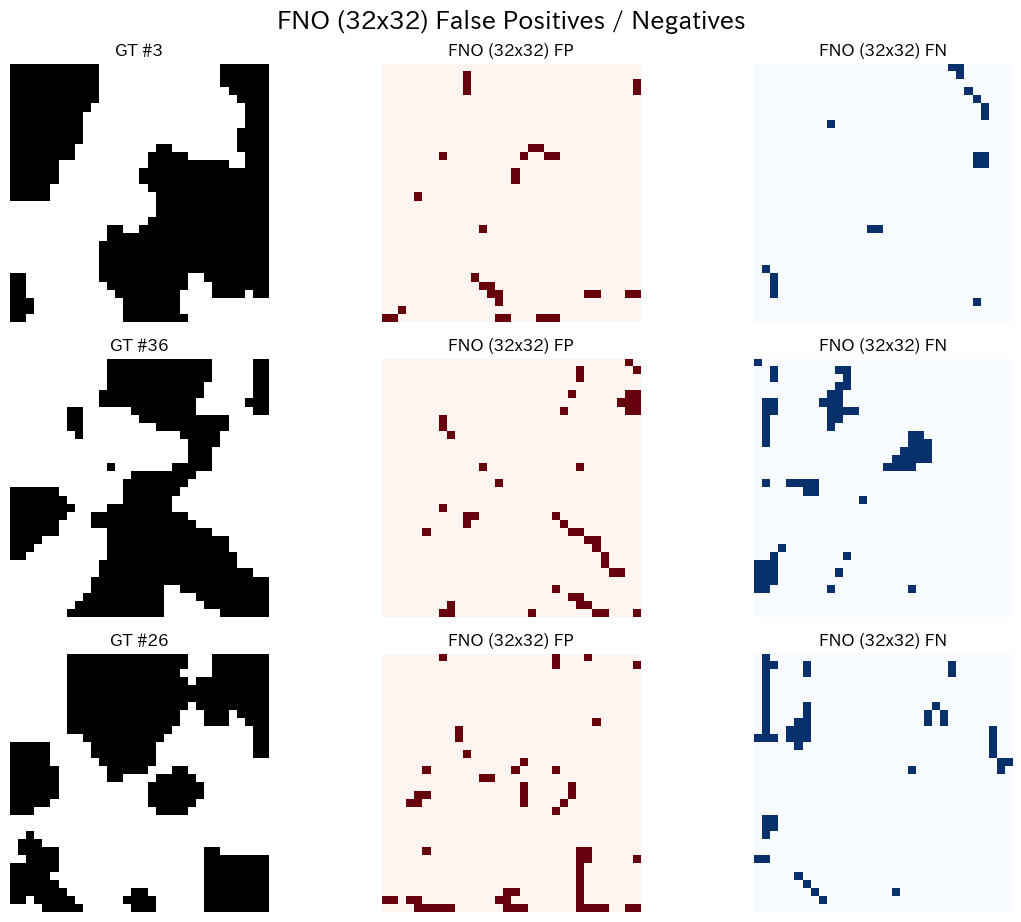

In [12]:
plot_prediction_and_error_maps(gt_images_32, preds_32,labels_32, num_samples=3)

plot_fp_fn_examples(pred_cno_32, y_test_32.cpu(), model_name="CNO (32x32)", num_samples=3)
plot_fp_fn_examples(pred_fno_32, y_test_32.cpu(), model_name="FNO (32x32)", num_samples=3)

